## ISMD (Inversed Synthesizable Molecular Design) Totorial

This tutorial will proceed as follow:

1. initial setup and data preparation
2. descriptor preparation for forward model (likelihood)
3. forward model (likelihood) preparation
4. proposal mdoel preparation 
5. a complete ismd run

### 1.1 import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import xenonpy
import onmt
from xenonpy.descriptor import Fingerprints
from xenonpy.contrib.ismd import GaussianLogLikelihood
from xenonpy.contrib.ismd import ReactionDescriptor
from xenonpy.contrib.ismd import ReactantPool
from xenonpy.contrib.ismd import Reactor
from xenonpy.contrib.ismd import ISMD

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

### 1.2 load data

In [2]:
# ground truth data
ground_truth_path = "/home/qiz/data/lab_database/ismd_data/STEREO_id_reactant_product_xlogp_tpsa.csv"
data = pd.read_csv(ground_truth_path)[:100000]
data.head()

,reactant_index,reactant,product,XLogP,TPSA
0,12163.22445,CCS(=O)(=O)Cl.OCCBr,CCS(=O)(=O)OCCBr,0.8,51.8
1,863.20896,CC(C)CS(=O)(=O)Cl.OCCCl,CC(C)CS(=O)(=O)OCCCl,1.6,51.8
2,249087,O=[N+]([O-])c1cccc2cnc(Cl)cc12,Nc1cccc2cnc(Cl)cc12,2.4,38.9
3,153658.23440,Cc1cc2c([N+](=O)[O-])cccc2c[n+]1[O-].O=P(Cl)(C...,Cc1cc2c([N+](=O)[O-])cccc2c(Cl)n1,3.3,58.7
4,297070,CCCCC[C@H](O)C=CC1C=CC(=O)C1CC=CCCCC(=O)O,CCCCC[C@H](O)C=CC1CCC(=O)C1CC=CCCCC(=O)O,3.8,74.6


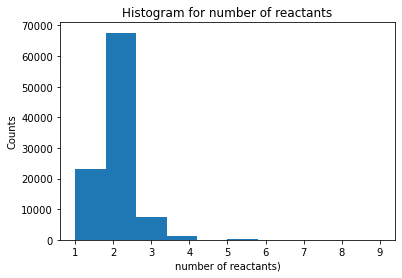

In [3]:
count = [len(reactants.split('.')) for reactants in data["reactant_index"]]
plt.hist(count, bins=10)  # arguments are passed to np.histogram
plt.title('Histogram for number of reactants')
plt.xlabel('number of reactants)')
plt.ylabel('Counts')
plt.show()

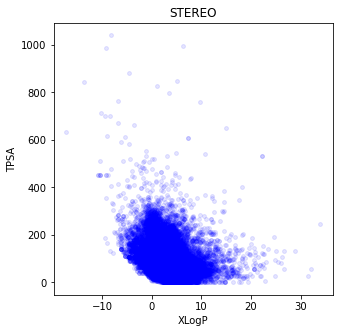

In [4]:
# check target properties: XLogP & TPSA
plt.figure(figsize=(5,5))
plt.scatter(data['XLogP'],data['TPSA'],s=15,c='b',alpha = 0.1)
plt.title('STEREO')
plt.xlabel('XLogP')
plt.ylabel('TPSA')
plt.show()

In [5]:
# reactant pool
reactant_pool_path = "/home/qiz/data/lab_database/ismd_data/STEREO_pool_df.csv"

reactant_pool = pd.read_csv(reactant_pool_path)

# show the first three elements in the reactant pool
reactant_pool.head()

,id,SMILES
0,0,O=C(Cl)Oc1ccc(Cc2ccc(C(F)(F)F)cc2)cc1
1,1,CCc1cc(C2CCN(C(=O)OC(C)(C)C)CC2)ccc1Nc1ncc(C(F...
2,2,CC(NC(=O)OCc1ccccc1)C(C)NC(=O)c1ccccc1O
3,3,OC[C@H]1NCC[C@@H]1O
4,4,C#CCCN1C(=O)c2ccccc2C1=O


In [6]:
# similarity matrix of reactant pool
sim_matrix_path = "/home/qiz/data/lab_database/ismd_data/ZINC_sim_sparse.npz"
reactant_pool_sim = scipy.sparse.load_npz(sim_matrix_path).tocsr()

# show the list of indice whose molecule is similar to the first one in the reactant pool
print(reactant_pool_sim[0,:].nonzero()[1].tolist())

[0, 9850, 11897, 23561, 25594, 28947, 30750, 31361, 44204, 46017, 76945, 118108, 145556, 145734, 164311, 186671, 205326, 207174, 209595, 215653, 218310, 222491, 224002, 232232, 233447, 252758, 274284, 278177, 288659, 291331, 294003, 294172, 300867, 306289, 307663, 331897, 334538, 335455, 343644, 360531, 364663, 365676, 376086, 378821, 412563, 442160, 443411, 452943, 460860, 479253, 487849, 491373, 499241, 500259, 523929, 525478, 528040, 559770, 567735, 568783, 582833, 584542, 586316, 588491, 595094, 599275, 601808, 603887, 617189]


### 2.1 descripter
data is transformed in the following flow:

index of reactant -> smiles of reactant -> smiles of product -> fingerprint of product

In [7]:
# take some samples (index of reactant)
samples = data[["reactant_index"]].sample(n=100)
print(samples)

          reactant_index
74650  9361.47874.632572
47138         52475.2461
55946             582139
11690       139066.40636
60405        38096.30275
...                  ...
86270        27004.40539
73276        10293.35471
55505         310845.536
79299      215908.185550
8010         14123.30667

[100 rows x 1 columns]


### 2.1.1 index of reactant -> smiles of reactant
Obtain the smiles by ReactantPool module via index

Note: the ReactantPool also used as proposal model in step 4

In [8]:
pool_obj = ReactantPool(pool_data=reactant_pool, similarity_matrix=reactant_pool_sim, splitter='.')

In [9]:
pool_obj.index2reactant(samples)

['CCN(CC)CC.CCS.O=C(Cl)c1sc(Cl)nc1C(F)(F)F',
 'O=C(Cl)OC(Cl)(Cl)Cl.O=C1CCC(=O)N1O',
 'O=C1C2=C(CCCC2)C(=O)N1c1ccc(Cl)c([N+](=O)[O-])c1',
 'CC(C)CCCCC#CC=O.COC(OC)OC',
 'C=Cc1ccncc1.NCCN',
 'CN1C(=O)n2c(nc3ccccc32)NC1(C)C.O=C([O-])[O-]',
 'CC(C)=O.Cc1[nH]c(-c2ccccc2)nc1CO',
 'O=C1COCCOCC(=O)NCCOCCOCCOCCOCCN1',
 'O=C([O-])[C@H](O)[C@@H](O)C(=O)[O-]',
 'CCN(CC)CC.COc1ccc2oc(C(=O)O)c(OC(C)C)c2c1.Nc1nnn[nH]1',
 'COc1ccc(P2(=S)SP(=S)(c3ccc(OC)cc3)S2)cc1.O=C(Nc1ccc(F)cc1)c1ccccn1',
 'Cc1cc([N+](=O)[O-])cc(C)c1N.ClC1=NCCC1',
 'COC(=O)c1cc(F)ccc1N.FC(F)(F)c1cccc2c(Cl)ccnc12',
 'CNC(=O)Nc1ccccc1.O=CC(Cl)(Cl)Cl',
 'O=P(Cl)(Cl)Cl.O=c1[nH]sc2ccccc12',
 'ClCc1ccc(Cl)cc1.O=C(Nc1ccc(-c2ccccc2)s1)c1ccccc1',
 'NNc1nccc2[nH]c(=O)ccc12',
 'Cc1[nH]cnc1CCN.Cc1cccc(OC(=N)NC#N)c1',
 'CCOC(=O)COc1c(C)cc(C(O)(C(F)(F)F)C(F)(F)F)cc1C.NCc1ccccc1',
 'C#CC(=O)O.C=C(C)CCCBr',
 'CCN1C(=O)CCCc2nc(N3CCN(Cc4ccccc4)CC3)ncc21',
 'CCOC(=O)C=C(N)SCC.O=Cc1ccncc1',
 'Nc1cc(C(=O)O)cc(S(N)(=O)=O)c1-c1ccccc1.Nc1cc(C(=O)O)cc([N+](

### 2.1.2 smiles of reactant -> fingerprint of product

In [10]:
# build molecular transformer (smiles of reactant -> smiles of product)
reactor_path = "/home/qiz/data/lab_database/models/STEREO_mixed_augm_model_average_20.pt"
ChemicalReactor = Reactor()
ChemicalReactor.build_reactor(model_list=[reactor_path], max_length=100, n_best=1, gpu=0)

In [11]:
# build fingerprint descriptor (smiles of product -> fingerprint of product)

RDKit_FPs = Fingerprints(featurizers=['ECFP', 'MACCS'], input_type='smiles')

In [12]:
# build reaction descriptor (index of reactant -> fingerprint of product)
# a combination of reactor and fingerprint descripter

RD = ReactionDescriptor(descriptor_calculator=RDKit_FPs,reactor=ChemicalReactor,reactant_pool=pool_obj)

In [13]:
sample_FPs = RD.transform(samples)
sample_FPs.head()

RDKit ERROR: [14:31:53] SMILES Parse Error: syntax error while parsing: CC(=O)N(CC(O)COc1ccc(C(C)(C)c2ccc(OCC(CN(C(C)=O)C3CC(C)(C)N(C)C(C)(C)C3)OC(C)=O)cc2)cc1)C1CC(C)(C)N(
RDKit ERROR: [14:31:53] SMILES Parse Error: Failed parsing SMILES 'CC(=O)N(CC(O)COc1ccc(C(C)(C)c2ccc(OCC(CN(C(C)=O)C3CC(C)(C)N(C)C(C)(C)C3)OC(C)=O)cc2)cc1)C1CC(C)(C)N(' for input: 'CC(=O)N(CC(O)COc1ccc(C(C)(C)c2ccc(OCC(CN(C(C)=O)C3CC(C)(C)N(C)C(C)(C)C3)OC(C)=O)cc2)cc1)C1CC(C)(C)N('


,maccs:0,maccs:1,maccs:2,maccs:3,maccs:4,maccs:5,maccs:6,maccs:7,maccs:8,maccs:9,...,ecfp3:2038,ecfp3:2039,ecfp3:2040,ecfp3:2041,ecfp3:2042,ecfp3:2043,ecfp3:2044,ecfp3:2045,ecfp3:2046,ecfp3:2047
74650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3 Log-likelihood calculator

Compute the log-likelihood given the samples(index of reactant)

In [14]:
%%time

# set target
prop = ['XLogP', 'TPSA']
target_range = {'XLogP': (5, 10), 'TPSA': (50, 100)}

# build Gaussian likelihood calculator and set the target of region of the properties
likelihood_calculator = GaussianLogLikelihood(descriptor=RD, targets = target_range)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 78.9 µs


In [15]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[["reactant_index"]], data[prop], test_size=0.33, random_state=42)
print(len(X_train),len(y_train))

67000 67000


In [16]:
# train forward models inside ismd
likelihood_calculator.fit(X_train, y_train)

RDKit ERROR: [14:47:49] SMILES Parse Error: extra open parentheses for input: 'CO/N=C(\C(=O)NC1C(=O)N2C(C(=O)OC(c3ccccc3)c3ccccc3)=C(CI)CS(=O)[C@H]12)c1csc(NC(c2ccccc2)(c2ccccc2)c2ccc'
RDKit ERROR: [14:47:49] SMILES Parse Error: syntax error while parsing: CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(=
RDKit ERROR: [14:47:49] SMILES Parse Error: Failed parsing SMILES 'CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(=' for input: 'CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(='
RDKit ERROR: [14:47:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 8 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [14:47:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [14:47:49] Can't kekulize mol.  Unkekulized atoms:

In [17]:
y_train_pred = likelihood_calculator.predict(X_train)
y_test_pred = likelihood_calculator.predict(X_test)

RDKit ERROR: [15:05:44] SMILES Parse Error: extra open parentheses for input: 'CO/N=C(\C(=O)NC1C(=O)N2C(C(=O)OC(c3ccccc3)c3ccccc3)=C(CI)CS(=O)[C@H]12)c1csc(NC(c2ccccc2)(c2ccccc2)c2ccc'
RDKit ERROR: [15:05:44] SMILES Parse Error: syntax error while parsing: CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(=
RDKit ERROR: [15:05:44] SMILES Parse Error: Failed parsing SMILES 'CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(=' for input: 'CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(='
RDKit ERROR: [15:05:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 8 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [15:05:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [15:05:44] Can't kekulize mol.  Unkekulized atoms:

In [18]:
y_train_pred

,XLogP: mean,XLogP: std,TPSA: mean,TPSA: std
59428,3.833226,1.197412,46.255403,16.579111
34957,6.643761,1.202718,44.604089,16.652559
4264,5.528950,1.192097,62.860351,16.505572
53791,4.396812,1.193354,38.744952,16.522999
82114,0.460227,1.203292,103.167557,16.660484
...,...,...,...,...
6265,1.945729,1.200975,80.218956,16.628415
54886,0.742541,1.197313,70.639278,16.577752
76820,4.376849,1.201616,29.702528,16.637278
860,2.998732,1.200071,65.812215,16.615893


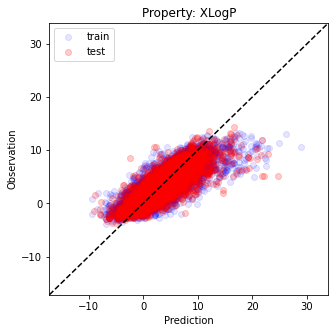

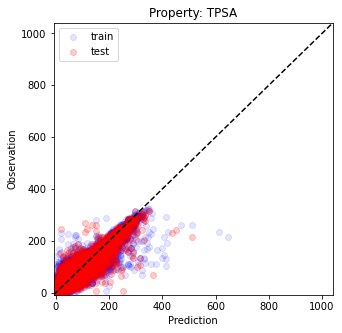

In [19]:
for property in ["XLogP","TPSA"]:

    xy_min = min(min(y_train[property]),min(y_test[property]),min(y_train_pred[property+": mean"]),min(y_test_pred[property+": mean"]))
    xy_max = max(max(y_train[property]),max(y_test[property]),max(y_train_pred[property+": mean"]),max(y_test_pred[property+": mean"]))
    plt.figure(figsize=(5,5))
    plt.scatter(y_train[property], y_train_pred[property+": mean"], c='b', alpha=0.1, label='train')
    plt.scatter(y_test[property], y_test_pred[property+": mean"], c='r', alpha=0.2, label='test')
    # plt.text(xy_min+xy_diff*0.7,xy_min+xy_diff*0.05,'MAE: %5.2f' % np.mean(np.abs(y_true - y_pred)),fontsize=12)
    plt.title('Property: ' + property)
    plt.xlim(xy_min,xy_max)
    plt.ylim(xy_min,xy_max)
    plt.legend(loc='upper left')
    plt.xlabel('Prediction')
    plt.ylabel('Observation')
    plt.plot([xy_min,xy_max],[xy_min,xy_max],ls="--",c='k')
    plt.show()

In [20]:
training_ll = likelihood_calculator(X_train)


RDKit ERROR: [15:31:58] SMILES Parse Error: extra open parentheses for input: 'CO/N=C(\C(=O)NC1C(=O)N2C(C(=O)OC(c3ccccc3)c3ccccc3)=C(CI)CS(=O)[C@H]12)c1csc(NC(c2ccccc2)(c2ccccc2)c2ccc'
RDKit ERROR: [15:31:58] SMILES Parse Error: syntax error while parsing: CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(=
RDKit ERROR: [15:31:58] SMILES Parse Error: Failed parsing SMILES 'CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(=' for input: 'CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(='
RDKit ERROR: [15:31:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 8 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [15:31:58] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [15:31:58] Can't kekulize mol.  Unkekulized atoms:

In [21]:
training_ll = training_ll.query("XLogP!='-inf' & XLogP!='-1000' & TPSA!='-inf' & TPSA!='-1000'")
min(training_ll["TPSA"])

-95.25594305119378

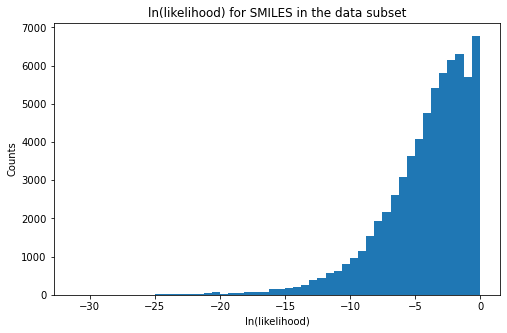

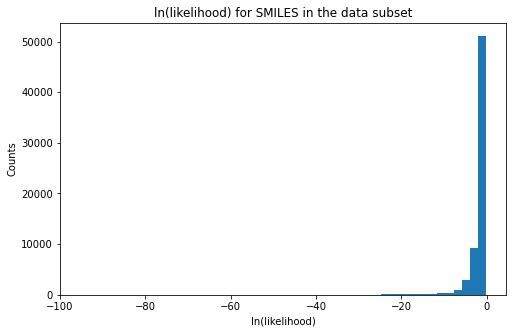

In [22]:
plt.figure(figsize=(8,5))
plt.hist(training_ll["XLogP"], bins=50)
plt.title('ln(likelihood) for SMILES in the data subset')
plt.xlabel('ln(likelihood)')
plt.ylabel('Counts')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(training_ll["TPSA"], bins=50)
plt.title('ln(likelihood) for SMILES in the data subset')
plt.xlabel('ln(likelihood)')
plt.ylabel('Counts')
plt.show()

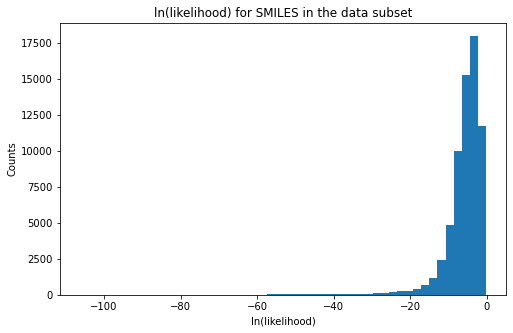

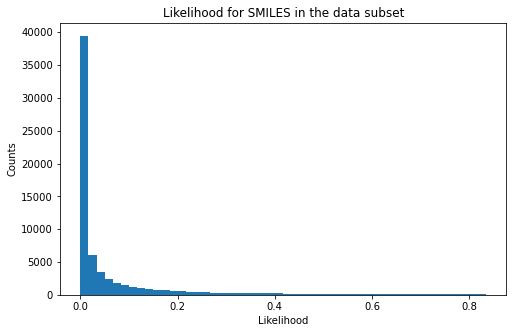

In [23]:

# plot histogram of log-likelihood values
tmp = training_ll.sum(axis = 1, skipna = True)

plt.figure(figsize=(8,5))
plt.hist(tmp, bins=50)
plt.title('ln(likelihood) for SMILES in the data subset')
plt.xlabel('ln(likelihood)')
plt.ylabel('Counts')
plt.show()

# plot histogram of likelihood values
plt.figure(figsize=(8,5))
plt.hist(np.exp(tmp), bins=50)
plt.title('Likelihood for SMILES in the data subset')
plt.xlabel('Likelihood')
plt.ylabel('Counts')
plt.show()

In [24]:
# predicted properties of samples
pred = likelihood_calculator.predict(data)
print(pred.head())

RDKit ERROR: [15:55:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 13
RDKit ERROR: 
RDKit ERROR: [15:55:36] Can't kekulize mol.  Unkekulized atoms: 6 13 14 15 22 23 24
RDKit ERROR: 
RDKit ERROR: [15:55:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 18 19
RDKit ERROR: 
RDKit ERROR: [15:55:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 18 19
RDKit ERROR: 
RDKit ERROR: [15:55:36] SMILES Parse Error: unclosed ring for input: 'CC(=O)O[C@H]1[C@]2(O)C[C@]3(O)SS[C@]4(CO)C(=O)N(C)C(=O)N3[C@@H]2C[C@@]13OC(C)C(C)(C)C3=O'
RDKit ERROR: [15:55:36] SMILES Parse Error: unclosed ring for input: 'COc1cccc(C23CCc4[nH]nc(O)c4C2)c1'
RDKit ERROR: [15:55:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8 9 10 12 13
RDKit ERROR: 
RDKit ERROR: [15:55:36] SMILES Parse Error: syntax error while parsing: CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](NC(=O)OCc1ccccc1)[C@@H](
RDKit ERROR: [15:55:3

   XLogP: mean  XLogP: std  TPSA: mean  TPSA: std
0     1.575004    1.190929   51.599437  16.489413
1     1.867665    1.193833   43.970658  16.529582
2     2.659310    1.194855   36.644529  16.543729
3     3.653536    1.195572   57.912854  16.553652
4     3.829884    1.202623   70.698016  16.651241


In [25]:
ll = likelihood_calculator(data)
ll = ll.query("XLogP!='-inf' & XLogP!='-1000' & TPSA!='-inf' & TPSA!='-1000'")
ll

RDKit ERROR: [16:20:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 13
RDKit ERROR: 
RDKit ERROR: [16:20:07] Can't kekulize mol.  Unkekulized atoms: 6 13 14 15 22 23 24
RDKit ERROR: 
RDKit ERROR: [16:20:07] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 18 19
RDKit ERROR: 
RDKit ERROR: [16:20:07] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 18 19
RDKit ERROR: 
RDKit ERROR: [16:20:07] SMILES Parse Error: unclosed ring for input: 'CC(=O)O[C@H]1[C@]2(O)C[C@]3(O)SS[C@]4(CO)C(=O)N(C)C(=O)N3[C@@H]2C[C@@]13OC(C)C(C)(C)C3=O'
RDKit ERROR: [16:20:07] SMILES Parse Error: unclosed ring for input: 'COc1cccc(C23CCc4[nH]nc(O)c4C2)c1'
RDKit ERROR: [16:20:07] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8 9 10 12 13
RDKit ERROR: 
RDKit ERROR: [16:20:07] SMILES Parse Error: syntax error while parsing: CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](NC(=O)OCc1ccccc1)[C@@H](
RDKit ERROR: [16:20:0

,XLogP,TPSA
0,-6.207447,-0.621814
1,-5.437994,-1.029193
2,-3.686566,-1.562137
3,-2.039925,-0.388349
4,-1.800090,-0.158004
...,...,...
99994,-2.894490,-0.223445
99995,-0.044959,-2.323193
99997,-0.180801,-2.358752
99998,-4.265454,-2.248797


In [26]:
valid_pred = pred[pred.index.isin(ll.index)]
valid_pred

,XLogP: mean,XLogP: std,TPSA: mean,TPSA: std
0,1.575004,1.190929,51.599437,16.489413
1,1.867665,1.193833,43.970658,16.529582
2,2.659310,1.194855,36.644529,16.543729
3,3.653536,1.195572,57.912854,16.553652
4,3.829884,1.202623,70.698016,16.651241
...,...,...,...,...
99994,3.103305,1.188958,64.823771,16.462147
99995,7.848389,1.191971,28.656958,16.503834
99997,6.183747,1.213052,27.943041,16.795528
99998,2.346943,1.208124,120.919468,16.727332


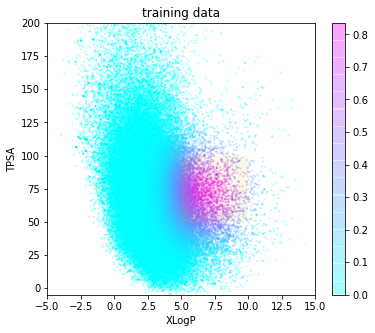

In [27]:
# check the predicted likelihood
dot_scale = 0.1
l_std = np.sqrt(valid_pred['XLogP: std']**2+valid_pred['TPSA: std']**2)
tmp = ll.sum(axis = 1, skipna = True)

plt.figure(figsize=(6,5))
rectangle = plt.Rectangle((target_range["XLogP"][0],target_range["TPSA"][0]),target_range["XLogP"][1]-target_range["XLogP"][0],target_range["TPSA"][1]-target_range["TPSA"][0],fc='y',alpha=0.1)
plt.gca().add_patch(rectangle)
im = plt.scatter(valid_pred['XLogP: mean'], valid_pred['TPSA: mean'], s=l_std*dot_scale, c=np.exp(tmp),alpha = 0.2,cmap=plt.get_cmap('cool'))
plt.title('training data')
plt.xlim([-5,15])
plt.ylim([-5,200])
plt.xlabel('XLogP')
plt.ylabel('TPSA')
plt.colorbar(im)
plt.show()

### 4 proposal model

proposal from the given reactant pool, sample(index of reactant) is modified by randomly changing one reactant to a similar one.

In [28]:
# proposal based on samples
new_samples = pool_obj.proposal(samples)
print(samples)
print(new_samples)

          reactant_index                                    reactant_SMILES  \
74650  9361.47874.632572           CCN(CC)CC.CCS.O=C(Cl)c1sc(Cl)nc1C(F)(F)F   
47138         52475.2461                 O=C(Cl)OC(Cl)(Cl)Cl.O=C1CCC(=O)N1O   
55946             582139   O=C1C2=C(CCCC2)C(=O)N1c1ccc(Cl)c([N+](=O)[O-])c1   
11690       139066.40636                          CC(C)CCCCC#CC=O.COC(OC)OC   
60405        38096.30275                                   C=Cc1ccncc1.NCCN   
...                  ...                                                ...   
86270        27004.40539                         C=CC(=O)O.c1ccc2[nH]ccc2c1   
73276        10293.35471                                  CN.O=C1C=CC(=O)O1   
55505         310845.536           CC1(C)Oc2cc3nc(S)[nH]c3cc2O1.ClCc1ccccn1   
79299      215908.185550       N#CC=CN1CCOCC1.O=[N+]([O-])C=Cc1cccc(Cl)c1Cl   
8010         14123.30667  Nc1ccc(-c2nc(-c3ccco3)no2)c(Cl)c1.O=C(Cl)Oc1cc...   

                                               prod

### 5 complete run of ismd

In [29]:
# set up initial reactants
cans = data.query("XLogP<3 & TPSA<50")
cans = cans.sample(n=100)
init_samples = cans[["reactant_index"]]
init_samples

,reactant_index
84937,50152.50803
61308,101485.46110
23,197566
73322,379219.10293
22108,547670
...,...
69016,36838.589417
63003,10396.51929
44774,41865.577400
72481,397011


In [30]:
# set up annealing schedule
beta = np.hstack([np.linspace(0.01,0.2,20),np.linspace(0.21,0.4,10),np.linspace(0.4,1,10),np.linspace(1,1,10)])
print('Number of steps: %i' % len(beta))
print(beta)

Number of steps: 50
[0.01       0.02       0.03       0.04       0.05       0.06
 0.07       0.08       0.09       0.1        0.11       0.12
 0.13       0.14       0.15       0.16       0.17       0.18
 0.19       0.2        0.21       0.23111111 0.25222222 0.27333333
 0.29444444 0.31555556 0.33666667 0.35777778 0.37888889 0.4
 0.4        0.46666667 0.53333333 0.6        0.66666667 0.73333333
 0.8        0.86666667 0.93333333 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [31]:
# set up likelihood and modifier models in iQSPR
ismd = ISMD(estimator=likelihood_calculator, modifier=pool_obj)
step = 0
np.random.seed(201906) # fix the random seed
# main loop of iQSPR
ismd_samples, ismd_loglike, ismd_prob, ismd_freq = [], [], [], []
for s, ll, p, freq in ismd(init_samples, beta, yield_lpf=True):
    step += 1
    print(step)
    ismd_samples.append(s)
    ismd_loglike.append(ll)
    ismd_prob.append(p)
    ismd_freq.append(freq)
# record all outputs
ismd_results = {
    "samples": ismd_samples,
    "loglike": ismd_loglike,
    "prob": ismd_prob,
    "freq": ismd_freq,
    "beta": beta
}


1


RDKit ERROR: [16:22:43] SMILES Parse Error: ring closure 2 duplicates bond between atom 11 and atom 12 for input: 'c1ccc2c(c1)CCCC21OC2(C2OCCO2)c2ccccc21'


2
3


RDKit ERROR: [16:22:47] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 7 8 9 11 13
RDKit ERROR: 


4


RDKit ERROR: [16:22:50] SMILES Parse Error: extra open parentheses for input: 'COc1c(C[C@H](NC(=O)C[C@H]2CC[C@H](N(C[C@H](C)NC(=O)Cc3ccc(C(=O)c4cccs4)cc3)C(=O)OC(C)(C)C)CC2)B2OC3CC4CC(C4(C)C)C3(C'


5
6
7


RDKit ERROR: [16:22:57] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 12 19
RDKit ERROR: 
RDKit ERROR: [16:22:57] SMILES Parse Error: extra close parentheses while parsing: CCCc1ccc(CNC(=O)[C@H]2CN(c3nc(-c4ccc(F)cc4)c4ccc(F)cc4)cs3)CCN2C(=O)OCc2ccccc2)cc1
RDKit ERROR: [16:22:57] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: no atoms
RDKit ERROR: Violation occurred on line 179 in file /opt/conda/conda-bld/rdkit_1585461230488/work/Code/GraphMol/ROMol.cpp
RDKit ERROR: Failed Expression: getNumAtoms() > 0
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [16:22:57] SMILES Parse Error: unclosed ring for input: 'CCc1ccc(C2(c3cc(Cl)ccc3O)OC(C)C(C)[N+](=O)[O-])cc1'


8


RDKit ERROR: [16:22:59] Can't kekulize mol.  Unkekulized atoms: 12 13 14
RDKit ERROR: 
RDKit ERROR: [16:22:59] Can't kekulize mol.  Unkekulized atoms: 5 6 7 14 15
RDKit ERROR: 


9
10


RDKit ERROR: [16:23:03] Can't kekulize mol.  Unkekulized atoms: 2 3 6 16 17
RDKit ERROR: 


11
12
13


RDKit ERROR: [16:23:10] SMILES Parse Error: extra open parentheses for input: 'CCOc1cc2c(c([N+](=O)[O-])c1OC(=O)C(C)(C)C2=O'


14
15
16
17
18


RDKit ERROR: [16:23:21] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 30
RDKit ERROR: 
RDKit ERROR: [16:23:21] Can't kekulize mol.  Unkekulized atoms: 4 5 7 10 11 12 13 14 15
RDKit ERROR: 


19


RDKit ERROR: [16:23:24] SMILES Parse Error: unclosed ring for input: 'CC1=NC2(N=C1SC(=O)c1ccccc12)c1cc(Br)ccc1CCC21CC1'


20


RDKit ERROR: [16:23:26] SMILES Parse Error: unclosed ring for input: 'COc1cc([N+](=O)[O-])ccc1-c1ccn2c(=O)C(C)(C)C2=O'


21
22
23


RDKit ERROR: [16:23:33] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(c1)C[C@@H](CCCCCCCCC[C@H](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(=O)O)[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC(=O)[C@H](CCC(F)(F)C(F)'
RDKit ERROR: [16:23:33] SMILES Parse Error: extra open parentheses for input: 'COC(=O)c1ccc(Cc2cn(C(=O)NC(c3ccccc3)c3ccccc3)c3ccc(N(Cc4cc(-c5cccc(C(F)(F)F)c5)on4)C(=O)OC4CCCC4)cc2'


24
25
26


RDKit ERROR: [16:23:41] SMILES Parse Error: extra open parentheses for input: 'COc1ccccc1C1(C(=O)NC2(c3cc(Br)ccc3CCC3(CCC(OC)CC3)C2)CC1'
RDKit ERROR: [16:23:41] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 28
RDKit ERROR: 


27


RDKit ERROR: [16:23:44] SMILES Parse Error: extra open parentheses for input: 'COc1ccc(C(=O)C23CCC(C(F)(F)F)CCC2(Cc2ccc(Br)cc2C3=O)CC1'


28


RDKit ERROR: [16:23:46] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


29
30


RDKit ERROR: [16:23:51] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 25 32 33
RDKit ERROR: 
RDKit ERROR: [16:23:51] SMILES Parse Error: unclosed ring for input: 'COc1cc(C(=O)Cc2cccc(-c3ccccc3C(F)(F)F)n2)ccc1Cc1cn(C(=O)NC(c2ccccc2)c2ccccc2)c2ccc(NC(=O)OC3CCCC3)cc'
RDKit ERROR: [16:23:51] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(c1)C[C@@H](CCCCCCCCC[C@H](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(=O)O)[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC(=O)[C@H](CCC(F)(F)C(F)'


31
32


RDKit ERROR: [16:23:55] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(c1)C[C@@H](CCCCCCCCC[C@H](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(=O)O)[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC(=O)[C@H](CCC(F)(F)C(F)'


33
34


RDKit ERROR: [16:24:00] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


35
36


RDKit ERROR: [16:24:04] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(c1)C[C@@H](CCCCCCCCC[C@H](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(=O)O)[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC(=O)[C@H](CCC(F)(F)C(F)'
RDKit ERROR: [16:24:04] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


37


RDKit ERROR: [16:24:06] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


38


RDKit ERROR: [16:24:08] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(c1)C[C@@H](CCCCCCCCC[C@H](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(=O)O)[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC(=O)[C@H](CCC(F)(F)C(F)'


39


RDKit ERROR: [16:24:11] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


40


RDKit ERROR: [16:24:13] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


41


RDKit ERROR: [16:24:15] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(c1)C[C@@H](CCCCCCCCC[C@H](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(=O)O)[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC(=O)[C@H](CCC(F)(F)C(F)'
RDKit ERROR: [16:24:15] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


42


RDKit ERROR: [16:24:17] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(c1)C[C@@H](CCCCCCCCC[C@H](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(=O)O)[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC(=O)[C@H](CCC(F)(F)C(F)'
RDKit ERROR: [16:24:17] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


43
44


RDKit ERROR: [16:24:21] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(c1)C[C@@H](CCCCCCCCC[C@H](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(=O)O)[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC(=O)[C@H](CCC(F)(F)C(F)'
RDKit ERROR: [16:24:21] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


45


RDKit ERROR: [16:24:24] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


46


RDKit ERROR: [16:24:26] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


47
48


RDKit ERROR: [16:24:30] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(c1)C[C@@H](CCCCCCCCC[C@H](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(=O)O)[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC(=O)[C@H](CCC(F)(F)C(F)'


49


RDKit ERROR: [16:24:32] SMILES Parse Error: extra open parentheses for input: 'COc1ccc2c(c1)C[C@@H](CCCCCCCCC[C@H](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(=O)O)[C@@H]1[C@@H]2CC[C@]2(C)[C@@H](OC(=O)[C@H](CCC(F)(F)C(F)'
RDKit ERROR: [16:24:32] SMILES Parse Error: unclosed ring for input: 'CN(CC=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCCCC[C@@H]1Cc2cc(O)ccc2[C@H]2[C@@H](F)C[C@]3(C)C(=O)CC[C@H]'


50


In [32]:
# have a look at the result
ismd_result_df = pd.DataFrame(ismd_results)
ismd_result_df.to_csv("/home/qiz/Result/ipynb_result.csv")
ismd_result_df.head()

,samples,loglike,prob,freq,beta
0,reactant_index r...,XLogP TPSA 0 -1.975656 -2.335382 ...,"[0.010244768079821907, 0.01005964398213206, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.01
1,reactant_index ...,XLogP TPSA 0 -4.574058 -0.339969 ...,"[0.010235241673373212, 0.010122943262240265, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...",0.02
2,reactant_index ...,XLogP TPSA 0 -5.209830 -0.66870...,"[0.009877013800992077, 0.008550946722652967, 0...","[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...",0.03
3,reactant_index ...,XLogP TPSA 0 -1.975656 -2.335382 ...,"[0.010460425482249668, 0.010889728061933805, 0...","[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.04
4,reactant_index ...,XLogP TPSA 0 -1.160997 -0.38462...,"[0.012088752878849456, 0.008620547991269078, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.05


In [33]:
len(ismd_result_df)

50

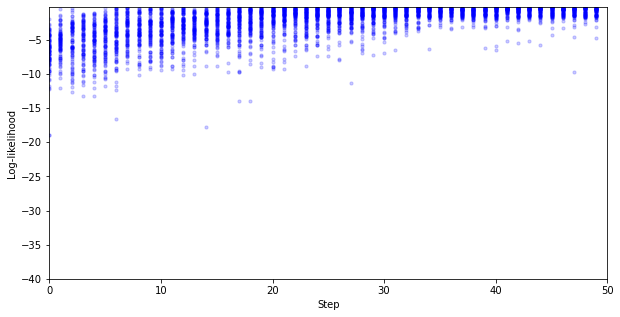

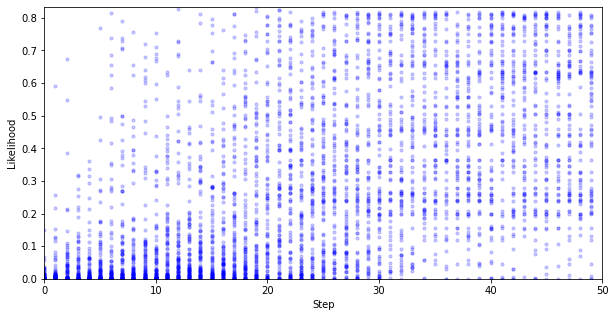

In [34]:
# plot the likelihood evolution

# set up the min and max boundary for the plots
tmp_list = [x.sum(axis = 1, skipna = True).values for x in ismd_result_df["loglike"]]
flat_list = np.asarray([item for sublist in tmp_list for item in sublist])
y_max, y_min = max(flat_list), min(flat_list)

plt.figure(figsize=(10,5))
plt.xlim(0,len(ismd_result_df["loglike"]))
plt.ylim(-40,y_max)
plt.xlabel('Step')
plt.ylabel('Log-likelihood')
for i, ll in enumerate(tmp_list):
    plt.scatter([i]*len(ll), ll ,s=10, c='b', alpha=0.2)
plt.show()
#plt.savefig('iqspr_loglike_reorder.png',dpi = 500)
#plt.close()

y_max, y_min = np.exp(y_max), np.exp(y_min)
plt.figure(figsize=(10,5))
plt.xlim(0,len(ismd_result_df["loglike"]))
plt.ylim(y_min,y_max)
plt.xlabel('Step')
plt.ylabel('Likelihood')
for i, ll in enumerate(tmp_list):
    plt.scatter([i]*len(ll), np.exp(ll) ,s=10, c='b', alpha=0.2)
plt.show()
#plt.savefig('iqspr_like_reorder.png',dpi = 500)
#plt.close()